In [1]:
import torch, platform
print("Python version:", platform.python_version())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU not detected")

Python version: 3.12.12
Torch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


For persistent storage mountung google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# setup project dirrectory, sub folders on DRive
PROJECT_DIR = '/content/drive/MyDrive/continual_learning_project'
for sub in ['environmentSetup','data', 'models', 'results', 'plots', 'logs']:
    os.makedirs(f"{PROJECT_DIR}/{sub}", exist_ok=True)
print("Project folder created successfully at:", PROJECT_DIR)

Project folder created successfully at: /content/drive/MyDrive/continual_learning_project


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [5]:
# converts images into numerical tensors suitable for neural networks
# Converts image (0-255) → normalized float tensor (0-1)
transform = transforms.Compose([
    transforms.ToTensor()
])

now get the MNIST dataset and split into train, validaate and test.

In [6]:
import json

full_train_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=True,  download=True, transform=transform)
test_dataset = datasets.MNIST(root=f'{PROJECT_DIR}/data', train=False, download=True, transform=transform)

SPLIT_DIR = f"{PROJECT_DIR}/data/splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

# seed to ensure same splits everytime
SEED = 42
g = torch.Generator().manual_seed(SEED)

# split test set into test and alidate
total_test = len(test_dataset)
val_size   = total_test // 2
test_size  = total_test - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size], generator=g)

loader_kwargs = dict(batch_size=64, num_workers=2, pin_memory=torch.cuda.is_available())
train_loader = DataLoader(full_train_dataset, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,      shuffle=False, **loader_kwargs)
test_loader  = DataLoader(final_test_dataset, shuffle=False, **loader_kwargs)

print("Train samples:", len(full_train_dataset))
print("Validation samples:", len(val_dataset))
print("Final Test samples:", len(final_test_dataset))

split_indices = {
    "train": list(range(len(full_train_dataset))),
    "val":   val_dataset.indices,
    "test":  final_test_dataset.indices,
}
with open(f"{SPLIT_DIR}/train_indices.json","w") as f: json.dump(split_indices["train"], f)
with open(f"{SPLIT_DIR}/val_indices.json","w")   as f: json.dump(split_indices["val"],   f)
with open(f"{SPLIT_DIR}/test_indices.json","w")  as f: json.dump(split_indices["test"],  f)




Train samples: 60000
Validation samples: 5000
Final Test samples: 5000


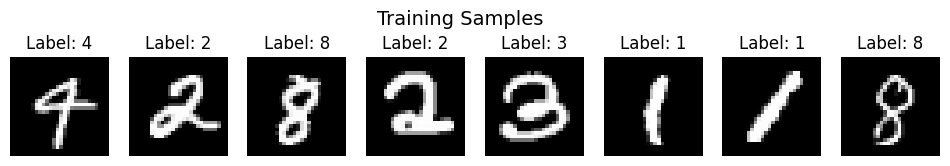

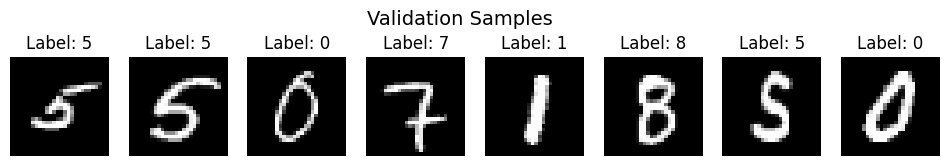

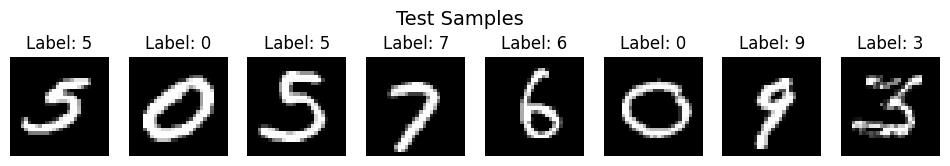

In [7]:
import matplotlib.pyplot as plt
def visualizeImages(data_loader, title="Sample Images"):
    images, labels = next(iter(data_loader))
    images, labels = images[:8], labels[:8]

    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    fig.suptitle(title, fontsize=14)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()
visualizeImages(train_loader, title="Training Samples")
visualizeImages(val_loader,   title="Validation Samples")
visualizeImages(test_loader,  title="Test Samples")

Verify class balance

In [8]:
from collections import Counter

labels = [label for _, label in full_train_dataset]
print(Counter(labels))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


Create a baseline model to compare against.
For task 1 -> only want pictures of 0 and 1; for task 2 only 2 and 3 pictures needed and so on.  
train per task on only that task’s digits,

after each task, evaluate on all tasks seen so far (0..t) on val + test,

log to CSV,

plot avg accuracy vs task index (to show forgetting).

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

# five binary tasks (Split-MNIST style)
TASKS = [(0,1), (2,3), (4,5), (6,7), (8,9)]

class TwoClassWrap(Dataset):
    def __init__(self, base_ds, a, b):
        self.base = base_ds
        self.keep = [i for i in range(len(base_ds)) if base_ds[i][1] in (a, b)]
        self.map = {a:0, b:1}
    def __len__(self): return len(self.keep)
    def __getitem__(self, i):
        x, y = self.base[self.keep[i]]
        return x, self.map[int(y)]

def make_task_loaders(train_ds, val_ds, test_ds, pair, batch=64):
    a, b = pair
    tr = TwoClassWrap(train_ds, a, b)
    va = TwoClassWrap(val_ds,   a, b)
    te = TwoClassWrap(test_ds,  a, b)
    kw = dict(batch_size=batch, num_workers=2, pin_memory=torch.cuda.is_available())
    return (DataLoader(tr, shuffle=True,  **kw),
            DataLoader(va, shuffle=False, **kw),
            DataLoader(te, shuffle=False, **kw))


In [10]:
# baseline model helper
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP2(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.fc2 = nn.Linear(hidden, 2)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_epoch(model, loader, opt, crit):
    model.train(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward(); opt.step()
        cor += (logits.argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

@torch.no_grad()
def eval_acc(model, loader):
    model.eval(); tot=0; cor=0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        cor += (model(xb).argmax(1)==yb).sum().item()
        tot += xb.size(0)
    return cor/tot

In [11]:
#  baseline model sequential run and log per task metrics
import os, pandas as pd, numpy as np, random, matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = f"{PROJECT_DIR}/results"
PLOTS_DIR   = f"{PROJECT_DIR}/plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

EPOCHS_BASELINE = 5
BATCH = 64
LR = 1e-3


train_base = full_train_dataset
val_base   = val_dataset
test_base  = final_test_dataset

model = MLP2().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.CrossEntropyLoss()

rows = []

for t_idx, pair in enumerate(TASKS):
    # loaders for the CURRENT task
    tr_loader, va_loader_curr, te_loader_curr = make_task_loaders(train_base, val_base, test_base, pair, batch=BATCH)

    # train on current task only
    for _ in range(EPOCHS_BASELINE):
        _ = train_epoch(model, tr_loader, opt, crit)

    # evaluate on ALL SEEN TASKS so far (0..t_idx) to measure forgetting
    for p_eval in TASKS[:t_idx+1]:
        _, va_eval, te_eval = make_task_loaders(train_base, val_base, test_base, p_eval, batch=BATCH)
        acc_val = eval_acc(model, va_eval)
        acc_tst = eval_acc(model, te_eval)
        rows.append(dict(
            method="baseline",
            after_task=t_idx,
            eval_on=str(p_eval),
            val_acc=acc_val,
            test_acc=acc_tst,
        ))

df = pd.DataFrame(rows)
csv_path = f"{RESULTS_DIR}/baseline_history.csv"
df.to_csv(csv_path, index=False)
print("saved:", csv_path)
df.tail()


saved: /content/drive/MyDrive/continual_learning_project/results/baseline_history.csv


,method,after_task,eval_on,val_acc,test_acc
10,baseline,4,"(0, 1)",0.168317,0.166335
11,baseline,4,"(2, 3)",0.694199,0.663415
12,baseline,4,"(4, 5)",0.203463,0.195789
13,baseline,4,"(6, 7)",0.853266,0.855701
14,baseline,4,"(8, 9)",0.993704,0.993204


In [12]:
MODELS_DIR = f"{PROJECT_DIR}/models"
os.makedirs(MODELS_DIR, exist_ok=True)

baseline_path = f"{MODELS_DIR}/baseline_model.pth"
torch.save(model.state_dict(), baseline_path)

print(f"Baseline model saved at: {baseline_path}")


Baseline model saved at: /content/drive/MyDrive/continual_learning_project/models/baseline_model.pth


Replay Method

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Simple rehearsal memory.
        Stores up to `capacity` (image, label) pairs from previous tasks.
        """
        self.capacity = capacity
        self.images = []
        self.labels = []

    def __len__(self):
        return len(self.images)

    def add_batch(self, x, y):
        """
        Add a batch of data using reservoir sampling.
        x: (batch_size, C, H, W)
        y: (batch_size,)
        """
        x = x.detach().cpu()
        y = y.detach().cpu()

        for i in range(x.size(0)):
            img = x[i]
            label = y[i]

            if len(self.images) < self.capacity:
                # Still space: just append
                self.images.append(img)
                self.labels.append(label)
            else:
                # Reservoir sampling: randomly replace an existing item
                j = np.random.randint(0, len(self.images) + 1)
                if j < self.capacity:
                    self.images[j] = img
                    self.labels[j] = label

    def sample(self, batch_size):
        """
        Random mini-batch from memory.
        """
        if len(self.images) == 0:
            raise ValueError("ReplayBuffer is empty!")

        batch_size = min(batch_size, len(self.images))
        idx = torch.randint(0, len(self.images), (batch_size,))
        imgs = torch.stack([self.images[i] for i in idx])
        labels = torch.stack([self.labels[i] for i in idx])
        return imgs, labels


In [14]:
def populate_buffer_from_loader(buffer, loader, max_batches=None):
    """
    Go through a dataloader and fill replay buffer with its samples.
    Stops when buffer full or `max_batches` reached.
    """
    for b, (xb, yb) in enumerate(loader):
        buffer.add_batch(xb, yb)
        if len(buffer) >= buffer.capacity:
            break
        if max_batches is not None and (b + 1) >= max_batches:
            break

    print(f"Replay buffer filled with {len(buffer)} examples.")

In [15]:
def train_epoch_with_replay(model, loader, opt, crit,
                            replay_buffer=None,
                            replay_ratio=0.5,
                            device=device):
    """
    Train for ONE epoch on `loader`, mixing in samples from replay_buffer.

    replay_ratio = fraction of each batch that comes from replay memory
                   (approx; we compute per batch).
    """
    model.train()
    tot = 0
    cor = 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        # Mix current batch with replay samples (if available)
        if (replay_buffer is not None) and (len(replay_buffer) > 0):
            replay_bs = int(xb.size(0) * replay_ratio)
            replay_bs = max(replay_bs, 1)
            replay_bs = min(replay_bs, len(replay_buffer))

            rx, ry = replay_buffer.sample(replay_bs)
            rx, ry = rx.to(device), ry.to(device)

            xb = torch.cat([xb, rx], dim=0)
            yb = torch.cat([yb, ry], dim=0)

        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()

        preds = logits.argmax(1)
        cor += (preds == yb).sum().item()
        tot += yb.size(0)

        # After updating, add *current-task* data into replay buffer
        if replay_buffer is not None:
            replay_buffer.add_batch(xb.detach().cpu(), yb.detach().cpu())

    return cor / tot

In [16]:
# ==== Replay-based continual learning run ====
import os, pandas as pd, numpy as np, random

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = f"{PROJECT_DIR}/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

EPOCHS_REPLAY = 5      # same as baseline for fair compare
BATCH_REPLAY = 64
LR_REPLAY     = 1e-3

BUFFER_CAPACITY = 2000   # experiment with 500, 1000, 2000
REPLAY_RATIO    = 0.5    # 50% of batch from memory

train_base = full_train_dataset
val_base   = val_dataset
test_base  = final_test_dataset

# fresh model for replay experiment
model_replay = MLP2().to(device)
opt_replay   = torch.optim.Adam(model_replay.parameters(), lr=LR_REPLAY)
crit         = nn.CrossEntropyLoss()

replay_buffer = ReplayBuffer(capacity=BUFFER_CAPACITY)

rows_replay = []

for t_idx, pair in enumerate(TASKS):
    print(f"\n=== Replay: Training on Task {t_idx} {pair} ===")
    tr_loader, va_loader_curr, te_loader_curr = make_task_loaders(
        train_base, val_base, test_base, pair, batch=BATCH_REPLAY
    )

    # Train on current task with replay
    for epoch in range(EPOCHS_REPLAY):
        acc_train = train_epoch_with_replay(
            model_replay,
            tr_loader,
            opt_replay,
            crit,
            replay_buffer=replay_buffer,
            replay_ratio=REPLAY_RATIO,
            device=device
        )
        print(f"  Epoch {epoch+1}: train acc (mixed) = {acc_train:.4f}")

    # Evaluate on ALL SEEN tasks so far (0..t_idx)
    for p_eval in TASKS[:t_idx+1]:
        _, va_eval, te_eval = make_task_loaders(
            train_base, val_base, test_base, p_eval, batch=BATCH_REPLAY
        )
        acc_val = eval_acc(model_replay, va_eval)
        acc_tst = eval_acc(model_replay, te_eval)
        rows_replay.append(dict(
            method="replay",
            after_task=t_idx,
            eval_on=str(p_eval),
            val_acc=acc_val,
            test_acc=acc_tst,
        ))
        print(f"  Eval on {p_eval}: val={acc_val:.4f}, test={acc_tst:.4f}")

df_replay = pd.DataFrame(rows_replay)
csv_path_replay = f"{RESULTS_DIR}/replay_history.csv"
df_replay.to_csv(csv_path_replay, index=False)
print("saved:", csv_path_replay)
df_replay.tail()



=== Replay: Training on Task 0 (0, 1) ===
  Epoch 1: train acc (mixed) = 0.9964
  Epoch 2: train acc (mixed) = 0.9993
  Epoch 3: train acc (mixed) = 0.9994
  Epoch 4: train acc (mixed) = 0.9997
  Epoch 5: train acc (mixed) = 0.9999
  Eval on (0, 1): val=0.9991, test=1.0000

=== Replay: Training on Task 1 (2, 3) ===
  Epoch 1: train acc (mixed) = 0.9608
  Epoch 2: train acc (mixed) = 0.9874
  Epoch 3: train acc (mixed) = 0.9941
  Epoch 4: train acc (mixed) = 0.9964
  Epoch 5: train acc (mixed) = 0.9979
  Eval on (0, 1): val=0.8056, test=0.8137
  Eval on (2, 3): val=0.9941, test=0.9961

=== Replay: Training on Task 2 (4, 5) ===
  Epoch 1: train acc (mixed) = 0.9839
  Epoch 2: train acc (mixed) = 0.9979
  Epoch 3: train acc (mixed) = 0.9992
  Epoch 4: train acc (mixed) = 0.9998
  Epoch 5: train acc (mixed) = 0.9999
  Eval on (0, 1): val=0.0819, test=0.0797
  Eval on (2, 3): val=0.9322, test=0.9141
  Eval on (4, 5): val=1.0000, test=0.9989

=== Replay: Training on Task 3 (6, 7) ===
  Epoc

,method,after_task,eval_on,val_acc,test_acc
10,replay,4,"(0, 1)",0.276328,0.269920
11,replay,4,"(2, 3)",0.690265,0.671220
12,replay,4,"(4, 5)",0.198052,0.186316
13,replay,4,"(6, 7)",0.849246,0.846620
14,replay,4,"(8, 9)",0.996852,0.994175


In [18]:
MODELS_DIR = f"{PROJECT_DIR}/models"
os.makedirs(MODELS_DIR, exist_ok=True)
replay_path = f"{MODELS_DIR}/replay_model.pth"
torch.save(model_replay.state_dict(), replay_path)
print(f"Replay model saved at: {replay_path}")

Replay model saved at: /content/drive/MyDrive/continual_learning_project/models/replay_model.pth


In [19]:
RESULTS_DIR = f"{PROJECT_DIR}/results"

df_base   = pd.read_csv(os.path.join(RESULTS_DIR, "baseline_history.csv"))
df_ewc    = pd.read_csv(os.path.join(RESULTS_DIR, "ewc_history.csv"))
df_replay = pd.read_csv(os.path.join(RESULTS_DIR, "replay_history.csv"))

df_all = pd.concat([df_base, df_ewc, df_replay], ignore_index=True)
df_all.head()

,method,after_task,eval_on,val_acc,test_acc
0,baseline,0,"(0, 1)",0.999100,1.000000
1,baseline,1,"(0, 1)",0.731773,0.774900
2,baseline,1,"(2, 3)",0.989184,0.990244
3,baseline,2,"(0, 1)",0.104410,0.119522
4,baseline,2,"(2, 3)",0.858407,0.855610


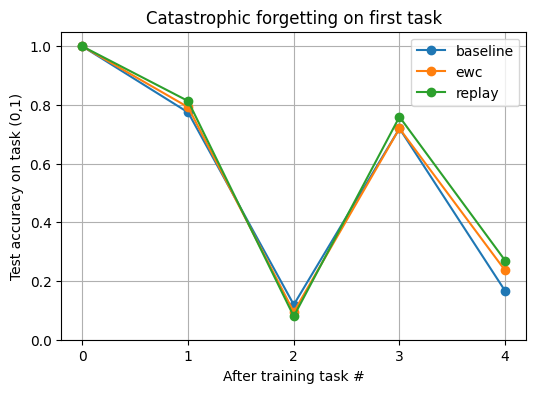

In [20]:
TASK0 = "(0, 1)"   # adjust if your string formatting is different

df_t0 = df_all[df_all["eval_on"] == TASK0].copy()

plt.figure(figsize=(6,4))
for method, sub in df_t0.groupby("method"):
    plt.plot(sub["after_task"], sub["test_acc"], marker="o", label=method)

plt.xlabel("After training task #")
plt.ylabel("Test accuracy on task (0,1)")
plt.title("Catastrophic forgetting on first task")
plt.xticks(range(df_t0["after_task"].min(), df_t0["after_task"].max()+1))
plt.ylim(0,1.05)
plt.legend()
plt.grid(True)
plt.show()